In [1]:
import data
import data.gene_datasets
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx

/u/weissmar/venv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tcgatissue = data.gene_datasets.TCGATissue()

Converting one-hot labels to integers


In [3]:
class Object(object):
    pass
opt = Object()
opt.seed = 0
opt.nb_class = None
opt.nb_examples = None
opt.nb_nodes = None
opt.graph = "pathway"
opt.dataset = tcgatissue

In [4]:
tcgatissue.set_graph(opt)


'Graph' object has no attribute 'labels'


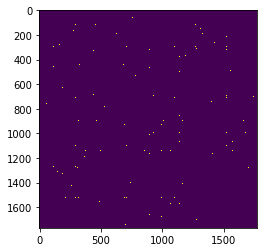

In [14]:
plt.imshow(tcgatissue.adj)

In [11]:
g = nx.from_numpy_matrix(tcgatissue.adj)
mapping = dict(zip(range(0, len(tcgatissue.df.columns)), tcgatissue.df.columns))
g = nx.relabel_nodes(g, mapping)

In [16]:
def lr(df, labels, trials, samples):
    scores = []
    for i in range(trials):
        X_train, X_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(df[:samples], labels[:samples], stratify=labels[:samples], train_size=0.5, random_state=i)

        model = sklearn.linear_model.LogisticRegression()
        model = model.fit(X_train, y_train)

        score = sklearn.metrics.roc_auc_score(y_test, model.predict(X_test))
        #print score
        scores.append(score)
    #print np.round(np.mean(scores),2),  np.round(np.std(scores),2)
    return np.round(np.mean(scores), 2),  np.round(np.std(scores),2)

In [13]:
genes_todo = [x for x in g.nodes() if len(list(g.neighbors(x)))>3]

In [14]:
genes_todo

['HSPA6',
 'HSPA5',
 'B2M',
 'PIK3CG',
 'NUP98',
 'PARP12',
 'CTBP2',
 'ITGA2',
 'ITGA3',
 'ITGA5',
 'ITGA7',
 'APOA4',
 'GPRASP1',
 'XPO1',
 'TTN',
 'TOP1',
 'ITGAM',
 'FOXC2',
 'GANAB',
 'SMAD9',
 'LRPAP1',
 'SMAD7',
 'SPARC',
 'SH2B3',
 'PIPOX',
 'SPP1',
 'ATP1A1',
 'EEF1A2',
 'FYCO1',
 'HOMER1',
 'CD44',
 'CFH',
 'CFB',
 'PRL',
 'RELN',
 'HMG20B',
 'TBL2',
 'UQCRC2',
 'PAK1',
 'KHDRBS2',
 'MED8',
 'MYCN',
 'IGF1',
 'TCF3',
 'NUDT4',
 'IGFBP2',
 'IGFBP3',
 'IGFBP5',
 'EPS8L2',
 'GAS8',
 'MEF2A',
 'MEF2D',
 'AMPD3',
 'TEX11',
 'PRKAR2B',
 'CFLAR',
 'TRADD',
 'UBE2D4',
 'ETFA',
 'CLIC1',
 'ATXN2L',
 'PRDX2',
 'PRDX1',
 'AP3S1',
 'FCGR2B',
 'FCGR2A',
 'SKIL',
 'AP2A2',
 'NSUN5',
 'TUBG2',
 'B3GAT3',
 'CACNA1I',
 'CALM1',
 'CUL2',
 'TRIM21',
 'SLC25A5',
 'GNPAT',
 'KIF5B',
 'CSF2RB',
 'NDRG1',
 'EGR1',
 'ZYX',
 'SLA',
 'RAD50',
 'PTPN9',
 'MYO1C',
 'RPS3',
 'RPS2',
 'PPBP',
 'OBSL1',
 'PDHA2',
 'LGALS1',
 'CP',
 'MYC',
 'FSCN1',
 'CSNK2B',
 'NMI',
 'PLAUR',
 'LOX',
 'RPL22',
 'IL1RAP',


In [18]:
# MLP, Decision tree, LR
# 100 trials
# possible to try with 1000 samples and 100
# put it in a dataframe and write it out
# gene name, full auc, full std, first degree auc/std, second degree auc/std, difference (first, second), list of neighbors for first degree, list of neighbors for second degree
for gene in genes_todo:
    df = tcgatissue.df
    labels = [1 if x > df[gene].mean() else 0 for x in df[gene]]
    df = df.drop(gene, axis=1)

    first_degree_neighbors = df.loc[:, list(g.neighbors(gene))].dropna(axis=1)
    full = lr(df, labels, 10, 100)
    first_degree = lr(first_degree_neighbors, labels, 10, 100)
    print gene + " full=" + str(full) + " first_degree=" + str(first_degree) + " diff=" + str(full[0] - first_degree[0])
    if (full[0] - first_degree[0]) < -0.05:
        print "#####" + gene

HSPA6 full=(0.67, 0.05) first_degree=(0.64, 0.07) diff=0.030000000000000027
HSPA5 full=(0.6, 0.05) first_degree=(0.66, 0.05) diff=-0.06000000000000005
#####HSPA5
B2M full=(0.74, 0.03) first_degree=(0.69, 0.04) diff=0.050000000000000044
PIK3CG full=(0.84, 0.04) first_degree=(0.86, 0.05) diff=-0.020000000000000018
NUP98 full=(0.75, 0.04) first_degree=(0.74, 0.04) diff=0.010000000000000009
PARP12 full=(0.69, 0.04) first_degree=(0.43, 0.04) diff=0.25999999999999995
CTBP2 full=(0.73, 0.06) first_degree=(0.51, 0.07) diff=0.21999999999999997
ITGA2 full=(0.8, 0.03) first_degree=(0.75, 0.05) diff=0.050000000000000044
ITGA3 full=(0.75, 0.07) first_degree=(0.66, 0.06) diff=0.08999999999999997
ITGA5 full=(0.72, 0.04) first_degree=(0.64, 0.05) diff=0.07999999999999996
ITGA7 full=(0.72, 0.04) first_degree=(0.52, 0.07) diff=0.19999999999999996
APOA4 full=(0.77, 0.04) first_degree=(0.69, 0.04) diff=0.08000000000000007
GPRASP1 full=(0.85, 0.05) first_degree=(0.55, 0.05) diff=0.29999999999999993
XPO1 fu

CHD7 full=(0.75, 0.07) first_degree=(0.73, 0.06) diff=0.020000000000000018
NPC1 full=(0.72, 0.06) first_degree=(0.69, 0.05) diff=0.030000000000000027
IL4R full=(0.78, 0.04) first_degree=(0.67, 0.04) diff=0.10999999999999999
RCN1 full=(0.61, 0.04) first_degree=(0.66, 0.05) diff=-0.050000000000000044
#####RCN1
ANKRD26 full=(0.64, 0.05) first_degree=(0.59, 0.04) diff=0.050000000000000044
SPI1 full=(0.79, 0.04) first_degree=(0.63, 0.04) diff=0.16000000000000003
ITPR1 full=(0.74, 0.05) first_degree=(0.64, 0.06) diff=0.09999999999999998
PLSCR1 full=(0.75, 0.07) first_degree=(0.51, 0.04) diff=0.24
VLDLR full=(0.66, 0.06) first_degree=(0.68, 0.04) diff=-0.020000000000000018
RNF128 full=(0.79, 0.04) first_degree=(0.59, 0.04) diff=0.20000000000000007
FCER1G full=(0.81, 0.04) first_degree=(0.77, 0.04) diff=0.040000000000000036
RPL3 full=(0.68, 0.05) first_degree=(0.73, 0.06) diff=-0.04999999999999993
HIST1H1E full=(0.62, 0.06) first_degree=(0.53, 0.04) diff=0.08999999999999997
BRWD1 full=(0.68, 0

VAV1 full=(0.77, 0.04) first_degree=(0.78, 0.05) diff=-0.010000000000000009
SDC2 full=(0.76, 0.05) first_degree=(0.74, 0.05) diff=0.020000000000000018
PDZD2 full=(0.73, 0.05) first_degree=(0.7, 0.06) diff=0.030000000000000027
HEYL full=(0.7, 0.07) first_degree=(0.62, 0.03) diff=0.07999999999999996
MAPK8 full=(0.69, 0.06) first_degree=(0.68, 0.08) diff=0.009999999999999898
RBL2 full=(0.65, 0.05) first_degree=(0.6, 0.03) diff=0.050000000000000044
GLB1 full=(0.66, 0.07) first_degree=(0.57, 0.04) diff=0.09000000000000008
STAT5A full=(0.72, 0.06) first_degree=(0.56, 0.03) diff=0.15999999999999992
FBL full=(0.71, 0.04) first_degree=(0.74, 0.04) diff=-0.030000000000000027
DGKZ full=(0.67, 0.08) first_degree=(0.57, 0.04) diff=0.10000000000000009
SERPINA1 full=(0.83, 0.04) first_degree=(0.62, 0.04) diff=0.20999999999999996
SERPINA3 full=(0.69, 0.06) first_degree=(0.54, 0.04) diff=0.1499999999999999
PLOD2 full=(0.72, 0.06) first_degree=(0.64, 0.06) diff=0.07999999999999996
GNA14 full=(0.81, 0.05

RIN1 full=(0.76, 0.06) first_degree=(0.56, 0.07) diff=0.19999999999999996
MET full=(0.77, 0.06) first_degree=(0.62, 0.08) diff=0.15000000000000002
EMP3 full=(0.79, 0.06) first_degree=(0.64, 0.07) diff=0.15000000000000002
EMP1 full=(0.72, 0.07) first_degree=(0.69, 0.04) diff=0.030000000000000027
RPS10 full=(0.64, 0.05) first_degree=(0.81, 0.05) diff=-0.17000000000000004
#####RPS10
ARL1 full=(0.7, 0.06) first_degree=(0.67, 0.05) diff=0.029999999999999916
RIPK1 full=(0.61, 0.05) first_degree=(0.62, 0.05) diff=-0.010000000000000009
RIPK2 full=(0.71, 0.05) first_degree=(0.6, 0.06) diff=0.10999999999999999
ULK2 full=(0.72, 0.05) first_degree=(0.58, 0.05) diff=0.14
TFAM full=(0.67, 0.05) first_degree=(0.7, 0.06) diff=-0.029999999999999916
TNC full=(0.69, 0.06) first_degree=(0.6, 0.05) diff=0.08999999999999997
SRPK1 full=(0.79, 0.05) first_degree=(0.75, 0.06) diff=0.040000000000000036
ACTN1 full=(0.82, 0.03) first_degree=(0.62, 0.05) diff=0.19999999999999996
PTPRC full=(0.85, 0.04) first_degre

CD63 full=(0.77, 0.06) first_degree=(0.67, 0.05) diff=0.09999999999999998
LRP1 full=(0.73, 0.05) first_degree=(0.67, 0.05) diff=0.05999999999999994
PLXNA1 full=(0.78, 0.03) first_degree=(0.69, 0.04) diff=0.09000000000000008
MAP2K7 full=(0.64, 0.06) first_degree=(0.59, 0.04) diff=0.050000000000000044
MAP2K4 full=(0.62, 0.07) first_degree=(0.58, 0.06) diff=0.040000000000000036
NEFL full=(0.78, 0.05) first_degree=(0.66, 0.05) diff=0.12
SEC31B full=(0.61, 0.06) first_degree=(0.7, 0.06) diff=-0.08999999999999997
#####SEC31B
SUV39H2 full=(0.77, 0.04) first_degree=(0.66, 0.05) diff=0.10999999999999999
SUCLG1 full=(0.67, 0.04) first_degree=(0.62, 0.07) diff=0.050000000000000044
LPL full=(0.72, 0.04) first_degree=(0.64, 0.05) diff=0.07999999999999996
MSR1 full=(0.79, 0.05) first_degree=(0.6, 0.06) diff=0.19000000000000006
CSNK1E full=(0.68, 0.07) first_degree=(0.56, 0.06) diff=0.12
CSNK2A2 full=(0.54, 0.08) first_degree=(0.51, 0.04) diff=0.030000000000000027
GFRA1 full=(0.76, 0.05) first_degree

In [ ]:
np.where(tcgatissue.df.columns[:] == "EVC")

In [112]:
dataset.node_names

<HDF5 dataset "gene_names": shape (16300,), type "|S64">

In [ ]:
lr(dataset.df, dataset.labels, 10, 100)

In [ ]:
lr(first_degree_neighbors, dataset.labels, 10, 100)

In [76]:
dataset.gene_to_infer
scores = []
for i in range(10):
    samples = 100
    first_degree_neighbors = dataset.df.loc[:, list(g.neighbors("CD53"))].dropna(axis=1)
    X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(first_degree_neighbors[:samples], dataset.labels[:samples], stratify=dataset.labels[:samples], train_size=0.5, random_state=i)

    model = sklearn.linear_model.LogisticRegression()
    model = model.fit(X_train, y_train)

    score = sklearn.metrics.roc_auc_score(model.predict(X_test),y_test)
    #print score
    scores.append(score)
print np.round(np.mean(scores),2),  np.round(np.std(scores),2)

/u/weissmar/venv/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """


0.82 0.04


In [ ]:
list(g.neighbors("REST"))